In [1]:
import os
import glob
import datetime
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
import numpy as np
from IPython.display import display, Math, Latex
import angles

import netCDF4 as nc
from scipy.optimize import curve_fit
from salishsea_tools import (viz_tools,tidetools, nc_tools)
from salishsea_tools.nowcast import (research_VENUS, analyze)

%matplotlib inline

In [2]:
path = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
to=datetime.datetime(2015,5,20)
tf=datetime.datetime(2015,5,28)
filesu=analyze.get_filenames(to,tf, '1h', 'grid_U', path)
filesv=analyze.get_filenames(to,tf,'1h', 'grid_V', path)

In [3]:
grid_B = nc.Dataset('/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
lats = grid_B.variables['nav_lat'][:]
lons = grid_B.variables['nav_lon'][:]
bathy = grid_B.variables['Bathymetry'][:,:]

In [48]:
jss=np.arange(0, 898)
iss=np.arange(0, 398)

u_u, time = analyze.combine_files(filesu, 'vozocrtx', 0, jss, iss)
v_v, time = analyze.combine_files(filesv, 'vomecrty', 0, jss, iss)
time = tidetools.convert_to_seconds(time)
dep_t = nc.Dataset(filesv[-1]).variables['depthv']

In [47]:
print u_u.shape
for i in iss:
    for j in jss:
        u = (u[:, j, i-1] + u[:, j, i]) / 2
        v = (v[:, j, i] + v[:, j-1, i]) / 2

(216, 898, 398)


IndexError: too many indices for array

In [34]:
def fittit (uaus, time, imin=0, imax=0, jmin=0, jmax=0, dj=0):
    
#CASE 1: DEPTH    
    if uaus.ndim==2:
        
        thesize=uaus.shape[1]
        M2amp = np.zeros(thesize) 
        M2pha = np.zeros(thesize)
        K1amp = np.zeros(thesize)
        K1pha = np.zeros(thesize)
        
        for dep in np.arange(0, len(uaus[1])-1):
            if uaus[:, dep].any() != 0:
                fitted, cov = curve_fit(tidetools.double, time[:], uaus[:, dep])
                if fitted[0] < 0:
                    fitted[0] = -fitted[0]
                    fitted[1] = fitted[1]+180.
                angles.normalize(fitted[1],-180, 180)
                if fitted[2] < 0:
                    fitted[2] = -fitted[2]
                    fitted[3] = fitted[3]+180.
                angles.normalize(fitted[3],-180, 180)
                M2amp[dep] = fitted[0]
                M2pha[dep] = fitted[1]
                K1amp[dep] = fitted[2]
                K1pha[dep] = fitted[3]

#CASE 2: SURFACE
    elif uaus.ndim==3:
        
        thesize = (898, 398)
        M2amp = np.zeros(thesize) 
        M2pha = np.zeros(thesize)
        K1amp = np.zeros(thesize)
        K1pha = np.zeros(thesize)
        
        for i in np.arange(imin,imax):
            for j in np.arange(jmin,jmax,dj):
                if uaus[:, i, j].any() != 0.:
                    fitted, cov = curve_fit(tidetools.double,time[:],uaus[:,i , j]) 
                    if fitted[0] < 0:
                        fitted[0] = -fitted[0]
                        fitted[1] = fitted[1]+180.
                    angles.normalize(fitted[1],-180, 180)
                    if fitted[2] < 0:
                        fitted[2] = -fitted[2]
                        fitted[3] = fitted[3]+180.
                    angles.normalize(fitted[3],-180, 180)
                    M2amp[i,j] = fitted[0]
                    M2pha[i,j] = fitted[1]
                    K1amp[i,j] = fitted[2]
                    K1pha[i,j] = fitted[3]


#CASE 3: DEPTH-AVERAGED
    else:
        
        M2amp = 0
        M2pha = 0
        K1amp = 0
        K1pha = 0
        
        if uaus[:].any() != 0.:
            fitted, cov = curve_fit(tidetools.double, time[:], uaus[:])
            if fitted[0] < 0:
                fitted[0] = -fitted[0]
                fitted[1] = fitted[1]+180.
            angles.normalize(fitted[1],-180, 180)
            if fitted[2] < 0:
                fitted[2] = -fitted[2]
                fitted[3] = fitted[3]+180.
            angles.normalize(fitted[3],-180, 180)
            
            M2amp = fitted[0]
            M2pha = fitted[1]
            K1amp = fitted[2]
            K1pha = fitted[3]


    return M2amp, M2pha, K1amp, K1pha

In [35]:
imin = 379; imax = 461; jmin = 238; jmax=320 
uM2amp, uM2pha, uK1amp, uK1pha = fittit(u, time, imin=imin, imax=imax, jmin=jmin, jmax=jmax, dj=2)
vM2amp, vM2pha, vK1amp, vK1pha = fittit(v, time, imin=imin, imax=imax, jmin=jmin, jmax=jmax, dj=2)

In [36]:
CX, SX, CY, SY, ap, am, ep, em, major, minor, theta = tidetools.ellipse_params (uM2amp, uM2pha, vM2amp, vM2pha)

Green ellipse = 0.5 m/s, red is clockwise


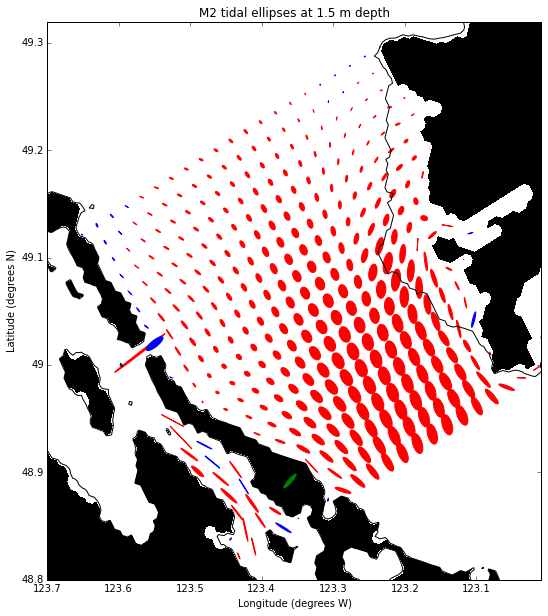

In [37]:
imin = 379; imax = 461; jmin = 238; jmax=320 
phi = 29. # the twist in the grid
k = np.zeros((898,398)); m = np.zeros((898,398))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
viz_tools.set_aspect(ax) 
ex = 50
for i in np.arange(imin-ex,imax+ex):
    for j in np.arange(jmin-ex,jmax+ex):
        k[i,j] = i*np.cos(phi*np.pi/180.)+j*np.sin(phi*np.pi/180.)
        m[i,j] = -i*np.sin(phi*np.pi/180.)+j*np.cos(phi*np.pi/180.) 
scale = 8.
interval = 4
for i in np.arange(imin-1,imax,interval):
    for j in np.arange(jmin,jmax,interval):
        if ap[i,j] > am[i,j]:
            thec = 'b'
        else:
            thec = 'r'
        ells = Ellipse(xy=(m[i,j],k[i,j]), width=scale*major[i,j], 
                            height=scale*minor[i,j], angle=theta[i,j]+29.,
                            color=thec)
        ax.add_artist(ells)
        ells.set_facecolor(thec)
# y-axis in k, but labelled in latitude
ax.set_ylim(445,560)
slope = (lats[imax,jmin]-lats[imin,jmin])/(k[imax,jmin]-k[imin,jmin])
mylist = (k[imin,jmin]+(np.arange(48.8, 49.35, 0.1)-
                           lats[imin,jmin])/slope).tolist()
labels = ['48.8', '48.9', '49', '49.1', '49.2', '49.3']
ax.set_yticks(mylist); ax.set_yticklabels(labels)
ax.set_ylabel('Latitude (degrees N)')
# x-axis in m, but labelled in longitude
ax.set_xlim(-14,94)
slope = (lons[imin,jmax]-lons[imin,jmin])/(m[imin,jmax]-m[imin,jmin])
mylist = (m[imin,jmin]+(np.arange(-123.7,-123.05,0.1)-
                        lons[imin,jmin])/slope).tolist()
labels = ['123.7','123.6','123.5','123.4','123.3','123.2','123.1','123']
ax.set_xticks(mylist); ax.set_xticklabels(labels)
ax.set_xlabel('Longitude (degrees W)')

# scale ellipse
ell = Ellipse(xy=(35,465),width = scale*0.5, height = scale*0.1, angle = 45,
              color='g')
ax.add_artist(ell)

# land, and 5 m contour
contour_interval = [-0.01, 0.01]
ax.contourf(m[imin-ex:imax+ex,jmin-ex:jmax+ex],k[imin-ex:imax+ex,jmin-ex:jmax+ex],
            bathy.data[imin-ex:imax+ex,jmin-ex:jmax+ex],contour_interval,colors='black')
ax.contour(m[imin-ex:imax+ex,jmin-ex:jmax+ex],k[imin-ex:imax+ex,jmin-ex:jmax+ex],
            bathy.data[imin-ex:imax+ex,jmin-ex:jmax+ex],[5],colors='black')
ax.set_title("M2 tidal ellipses at 1.5 m depth")

print "Green ellipse = 0.5 m/s, red is clockwise"